##Section 0. References
[GGplot Github](https://github.com/yhat/ggplot)

[Yhat Blog](blog.yhathq.com/posts/ggplot-for-python.html)

[Mann-Whitney Explanation Video](https://www.youtube.com/watch?v=nRAAAp1Bgnw)

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#df = pd.read_csv('turnstile_weather_v2.csv')
df = pd.read_csv('turnstile_data_master_with_weather.csv')
df.head()

,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890,1262,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451,3708,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400,2501,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0


##Section 1. Statistical Test
###1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?
We performed the Mann-Whitney U-test which is designed for evaluating whether the probability of choosing a random sample from one population  is larger than selecting a sample from another sample. We use a two-tail p value.  Our null hypothesis is that the number of people who ride the NYC Subway when it is raining is the same as the number of people who ride the NYC Subway when it is not raining.  Our p-critical value is 0.05
###1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.
We use this test since it is not dependent on whether the sample distribution is normal or not.


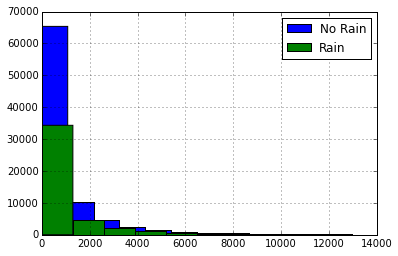

In [2]:
plt.figure()
plt.axis([0,14000,0,70000])
df[df['rain'] == 0]['ENTRIESn_hourly'].hist(bins=40,label='No Rain')
df[df['rain'] == 1]['ENTRIESn_hourly'].hist(bins=40, label= 'Rain')
plt.legend()

###1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.
We present the results generated by the Mann-Whitney U Test below.

In [3]:
entries_with_rain = df[df['rain'] == 1]['ENTRIESn_hourly']
entries_without_rain = df[df['rain'] == 0]['ENTRIESn_hourly']
with_rain_mean = entries_with_rain.mean()
without_rain_mean = entries_without_rain.mean()
results = scipy.stats.mannwhitneyu(entries_without_rain,entries_with_rain)
U = results[0]
p = results[1] * 2
with_rain_mean,without_rain_mean,results, p

(1105.4463767458733,
 1090.278780151855,
 MannwhitneyuResult(statistic=1924409167.0, pvalue=0.019309634413792565),
 0.038619268827585131)

The mean value of entries with rain is *1105.45* and the mean values of entries without rain is *1090.28*. The p-value after being doubled, since the scipy Mann-Whitney test returns a p-value for one-tailed test, is *0.038*.  Since the U test doesn't provide much information, we also provide some more descriptive statistics below.

In [4]:
entries_with_rain.describe()

count    44104.000000
mean      1105.446377
std       2370.527674
min          0.000000
25%         41.000000
50%        282.000000
75%       1103.250000
max      51839.000000
Name: ENTRIESn_hourly, dtype: float64

In [5]:
entries_without_rain.describe()

count    87847.000000
mean      1090.278780
std       2320.004938
min          0.000000
25%         38.000000
50%        278.000000
75%       1111.000000
max      43199.000000
Name: ENTRIESn_hourly, dtype: float64

###1.4 What is the significance and interpretation of these results?
Based off of the p-value the number of people who ride the subway when it is raining is statistically different than the number of people who ride the NYC subway when it is not raining.  Based off of the descriptive statistics, there is a higher median value for hourly entries when it was raining compared to the median of hourly entries when it is not raining.

##Section 2. Linear Regression
###2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
I used the Gradient Descent model which is apart of the the *sklearn* module in Python.
###2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?
I used the following variables for my features:
    - rain
    - precipi
    - hour
    - meantempi
    - day_week
    - pressurei
The *UNITS* were used as a dummy varaiable
###2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model.Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.”Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”
I chose *rain* and *precipi* because these features seem like that they would have a significant impact on predicting the ridership based on the weather.  I included *pressurei* since the barometric pressure is correlated to weather it is going to rain or not ( I learned this in a middle school project).  The remaining features were added because they gave me an improvement on my $R^2$ coefficient.



###2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
Before generating the parameters, we include a few helper functions that help us properly use the Gradient Descent function.  We need to normalize our features before passing them into the *SGDRegressor* function which represents our Gradient Descent model.

In [6]:
import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
df = pd.read_csv('turnstile_weather_v2.csv')

def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """
    #features = sm.add_constant(features)
    model = SGDRegressor(n_iter=50)
    #normalize_res = normalize_features(features)
    model.fit(features,values)
      
    ###########################
    ### YOUR CODE GOES HERE ###
    ###########################
    intercept = model.intercept_
    params = model.coef_
    return intercept, params


Now we generate our parameters and y-intercept below:

In [7]:
features = df[['rain', 'precipi', 'hour', 'meantempi','day_week','pressurei']]
dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(dummy_units)
# Values
values = df['ENTRIESn_hourly']
    
# Get numpy arrays
features_array = features.values
values_array = values.values
    
means, std_devs, normalized_features_array = normalize_features(features_array)

# Perform gradient descent
norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)
    
intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
predictions = intercept + np.dot(features_array, params)

print intercept
params



[ 21445.20188304]


array([  7.93840745e+01,  -2.60973264e+03,   1.23276603e+02,
        -1.90961334e+01,  -1.39172256e+02,  -6.40270323e+02,
        -1.79051327e+03,  -1.38409592e+03,  -1.32482533e+03,
        -1.42210090e+03,  -1.64103056e+03,  -1.50747704e+03,
        -1.66955520e+03,   6.45209641e+03,   5.68016066e+03,
         8.04593905e+02,  -1.12109202e+03,   3.29848606e+03,
         5.64530686e+03,   7.31729619e+02,   4.64308504e+03,
         2.31193759e+03,   6.04854011e+03,   4.59731228e+03,
         1.79367849e+03,   4.16828539e+03,   3.63636645e+02,
         6.11432272e+03,   1.46375658e+03,   1.77130432e+03,
         3.32096901e+03,   6.73473143e+03,  -5.76658600e+02,
         1.27564677e+03,  -1.18155348e+03,  -1.16459377e+03,
        -1.77027636e+03,  -9.75992690e+02,  -7.30149886e+02,
         1.60495094e+03,  -1.44622723e+03,   1.77254494e+03,
         1.93699338e+03,   5.95674456e+03,   1.10039650e+03,
         2.44549609e+03,   2.95547198e+03,  -5.44437171e+02,
         1.57060723e+03,

###2.5 What is your model’s R2 (coefficients of determination) value?
Our $R^2$ value is generated below which is 0.46.

In [8]:
mean = values.mean()
numerator = np.sum((values - predictions)**2)
denom = np.sum((values-mean)**2)
r_squared = 1 - numerator/denom
r_squared    

0.4600557374682288

###2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?
Based on our $R^2$ value, I don't believe that this linear model is very effective for this dataset as the coefficient is closer to 0 than it is to one.  I experimented with various features and increased the number of iterations up to 250 and the $R^2$ value that I have currently generated is the best one that I was able to generate.

##Section 3. Visualization
The first illustration is the histogram graph of the number of hourly entries based on whether it was raining(rain==1) or not(rain==0).  The last two visualizations are line trends to show how hourly entries vary across different times of the day as well as through different days of the week.

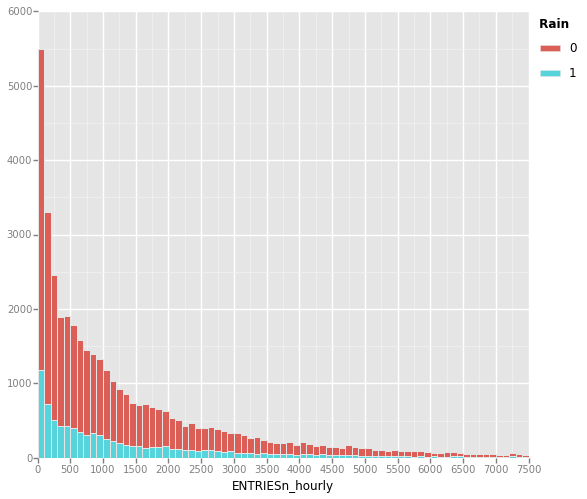

<ggplot: (51831773)>

In [12]:
from ggplot import *

df.is_copy=False
plot = ggplot(df, aes('ENTRIESn_hourly',fill='rain')) + geom_histogram(binwidth=100) + xlim(0,7500)

plot 

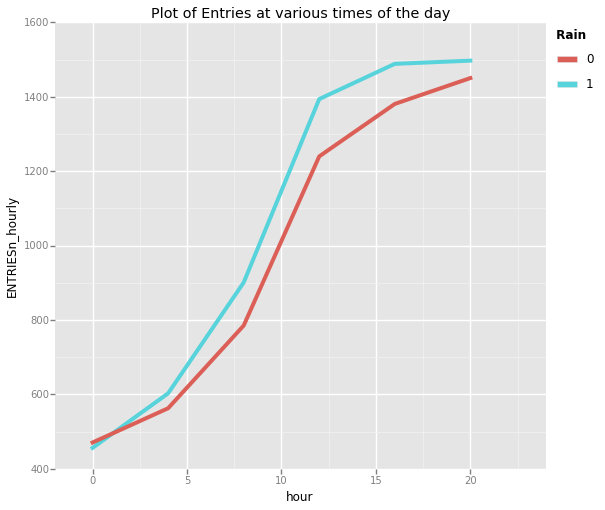

<ggplot: (51498546)>

In [10]:
plot = ggplot(df, aes('hour','ENTRIESn_hourly',color='rain')) + stat_smooth(se=False,size=4) + xlim(-2,24) + ggtitle('Plot of Entries at various times of the day')
plot

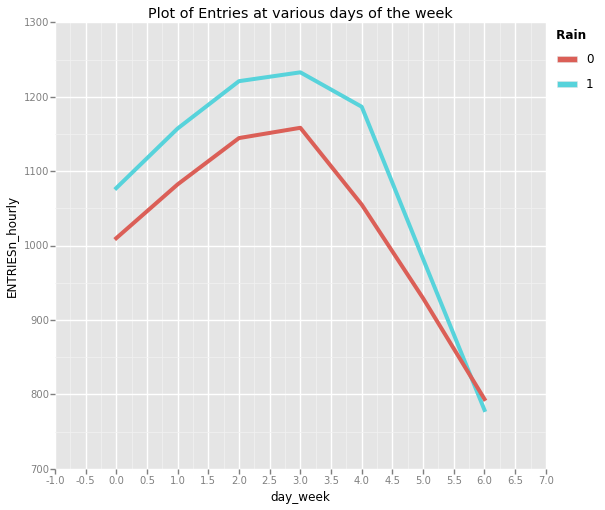

<ggplot: (51417387)>

In [11]:
plot = ggplot(df, aes('day_week','ENTRIESn_hourly',color='rain')) + stat_smooth(se=False, size=4) + xlim(-1,7) + ggtitle('Plot of Entries at various days of the week')
plot

##Section 4. Conclusion
###4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  
###4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.
From my analysis of the data, the data shows that more people ride the NYC subway when it is raining.  I have come to this conclusion from the results of our Mann-Whitney U test along with the descriptive statistics and visualization data generated in the responses above.  The Mann-Whitney U test gave us a *p-value* of 0.038 which, in our case, we would reject the null hypothesis which we defined as: "There is no difference between the subway ridership when it is raining and when it is not raining".  The p-value computed during the U test is less than our p-critical value of 0.05.  Thus we can conclude there is a statistical difference between the ridership when it is raining and when it is not raining on the NYC subway.  After analyzing the descriptive statistics, we see that the median value is larger for the number of hourly entries when it is raining compared to when it is not raining.  Analyzing the data visualizations, we can see the trend rate is higher in both the number of hourly entries per hour as well as over different days of the week for when it is raining.  The linear regression was not very accurate at predicting the the number of hourly entries in our model so this may lead for us to believe that our model is not very effective for drawing conclusions about the ridership on the NYC subway realtive to the weather(rain).


##Section 5. Reflection
###5.1 Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test.
###5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?
As stated in *Section 4*, the linear regression model was not very accurate as a predictive model.  Another shortcoming was the number of data points(Dataset) that we have for when it was raining; there were about twice as many data points for when it was not raining compared to the number of data points when it was raining.  This is probably expected in the month of May where the number of rainy days are few.  Perhaps an experiment comparing the ridership of a month with a more even distribution of rainy days and non-rainy days would have given us a better predictive model.